# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image
into one of two classes: "cat" or "dog". The code for the neural networks
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1dOYHUnpu5ZJsw_SnHmThRlIBVETIB4h9/view?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch

    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)

    val_sampler = SubsetRandomSampler(relevant_val_indices)

    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)

    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)

    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))

    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories.
We have included code that automatically downloads the dataset the
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=1) # One image per batch

Files already downloaded and verified
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

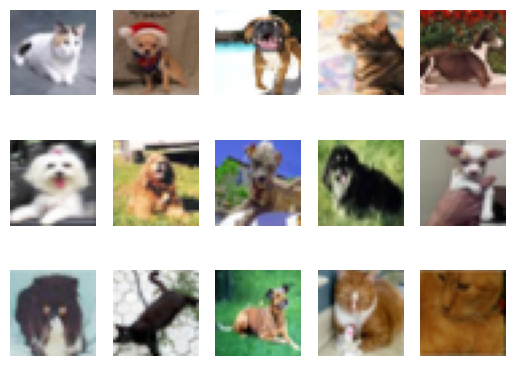

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes?
What about validation examples?
What about test examples?

In [ ]:
# Number of combined training examples:
print(len(train_loader))

8000


In [ ]:
# Number of combined validation examples:
print(len(val_loader))

2000


In [ ]:
# Number of combined test examples:
print(len(test_loader))

2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the
performance of our models using the training set loss/error instead of the validation
set loss/error?

**Why We Need a Validation Set:**
1. **Avoid Overfitting**: In case if a model is memorsing well in the training dataset, a validation set helps in detecting this overfitting situaion.
2. **Hyperparameter Tuning**: It can be helpful to use to determin the potential best set of hyperparameters for the model by evaluation the validation performance.
3. **Stop Training**: Early stopping can be implemented based on the validation performance to prevent overfitting and save our training time.

**If We Judge Performance Using Training Set Loss/Error:**
1. **Risk of Overfitting**: A model might have a low training error but may not generalize well to new, unseen data. Without a validtaion set, we risk choosing models that memorize the training data instead of learning general patterns.
2. **No Practical Feedback**: We won't have enough and proper feedback on how the model performs on unseen data, making it challenging to make informed decisions during training or hyperparameter tuning.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values.

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])


**The total number of parameters in `small_net`**:
- 5×3×3×3 + 5 + 1×245 + 1 = **386 parameters**

In [ ]:
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


**The total number of parameters in `large_net`**:
- 5×3×5×5 + 5 + 10×5×5×5 + 10 + 32×250 + 32 + 1×32 + 1 = **9705 parameters**

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]

    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)

    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)

        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on.

What are the default values of the parameters `batch_size`, `learning_rate`,
and `num_epochs`?

1. **`batch_size`**: Default value is **64**.
2. **`learning_rate`**: Default value is **0.01**.
3. **`num_epochs`**: Default value is **30**.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

**In total, we'll get 9 output files:**
- 5 model checkpoint files (one for each poch)
  - `small_net_bs64_lr0.01_epoch0`: Contains all the parameters (weights and biases) of the network for the first epoch.
  - `small_net_bs64_lr0.01_epoch1`: Contains all the parameters (weights and biases) of the network for the second epoch.
  - `small_net_bs64_lr0.01_epoch2`: Contains all the parameters (weights and biases) of the network for the third epoch.
  - `small_net_bs64_lr0.01_epoch3`: Contains all the parameters (weights and biases) of the network for the fourth epoch.
  - `small_net_bs64_lr0.01_epoch4`: Contains all the parameters (weights and biases) of the network for the fifth epoch.

- 4 CSV files (for training and validation errors and losses after iterating thr 5 epochs)
  - `small_net_bs64_lr0.01_epoch4_train_err.csv`: Contains training errors for all 5 epochs.
  - `small_net_bs64_lr0.01_epoch4_train_loss.csv`: Contains training losses for all 5 epochs.
  - `small_net_bs64_lr0.01_epoch4_val_err.csv`: Contains validation errors for all 5 epochs.
  - `small_net_bs64_lr0.01_epoch4_val_loss.csv`: Contains validation losses for all 5 epochs.

### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights)
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train? Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.424375, Train loss: 0.6749582901000977 |Validation err: 0.3715, Validation loss: 0.6553100515156984
Epoch 2: Train err: 0.362125, Train loss: 0.6453930578231811 |Validation err: 0.386, Validation loss: 0.6626564264297485
Epoch 3: Train err: 0.35525, Train loss: 0.6317213139533997 |Validation err: 0.3435, Validation loss: 0.6255243103951216
Epoch 4: Train err: 0.339125, Train loss: 0.6180766582489013 |Validation err: 0.345, Validation loss: 0.6247693058103323
Epoch 5: Train err: 0.332125, Train loss: 0.6128838138580323 |Validation err: 0.3395, Validation loss: 0.6224557682871819
Epoch 6: Train err: 0.32125, Train loss: 0.6030904016494751 |Validation err: 0.342, Validation loss: 0.6208562292158604
Epoch 7: Train err: 0.319375, Train loss: 0.5979298536777496 |Validation err: 0.3415, Validation loss: 0.6115294378250837
Epoch 8: Train err: 0.312375, Train loss: 0.5902269916534424 |Validation er

In [ ]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.439375, Train loss: 0.689647943019867 |Validation err: 0.423, Validation loss: 0.6791924238204956
Epoch 2: Train err: 0.40625, Train loss: 0.6736005911827088 |Validation err: 0.4135, Validation loss: 0.6772365085780621
Epoch 3: Train err: 0.381875, Train loss: 0.6552878866195678 |Validation err: 0.3565, Validation loss: 0.6365736369043589
Epoch 4: Train err: 0.360875, Train loss: 0.6355869131088256 |Validation err: 0.3655, Validation loss: 0.638199619948864
Epoch 5: Train err: 0.34325, Train loss: 0.6161627016067505 |Validation err: 0.321, Validation loss: 0.6084728688001633
Epoch 6: Train err: 0.328875, Train loss: 0.60091348528862 |Validation err: 0.3135, Validation loss: 0.599386278539896
Epoch 7: Train err: 0.310125, Train loss: 0.5881933116912842 |Validation err: 0.3255, Validation loss: 0.5969546306878328
Epoch 8: Train err: 0.306625, Train loss: 0.5685337216854095 |Validation err: 0

**Summary**
> **`small_net`**
  - Running time: 155.88 seconds

> **`large_net`**
  - Running time: 180.27 seconds

**Result**
- The `large_net` takes longer to train than the `small_net`. This increased training time is attributed to the greater number of parameters and layers in `large_net`. During each epoch of training, the `large_net` has to process more computations than the `small_net`, leading to the extended duration.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

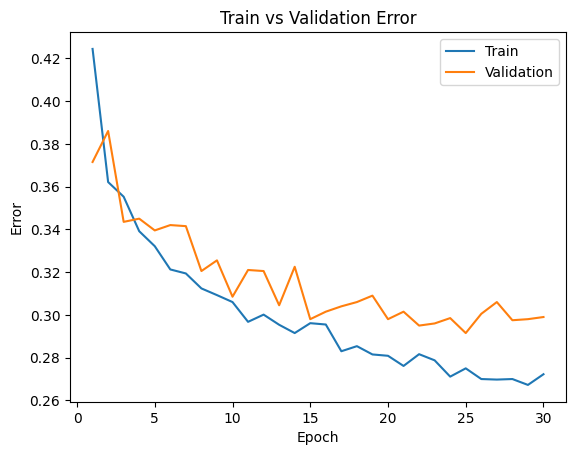

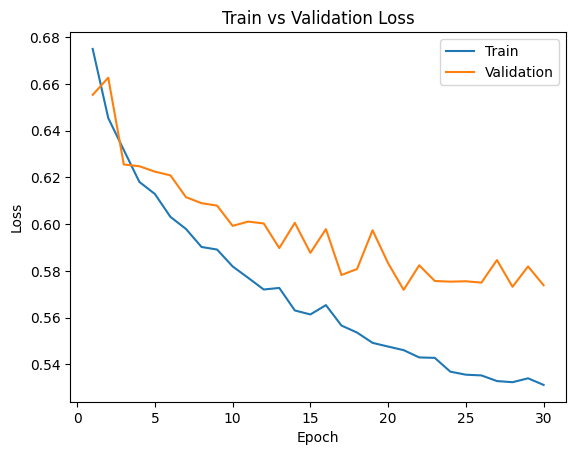

In [ ]:
# For the small_net
small_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(small_model_path)

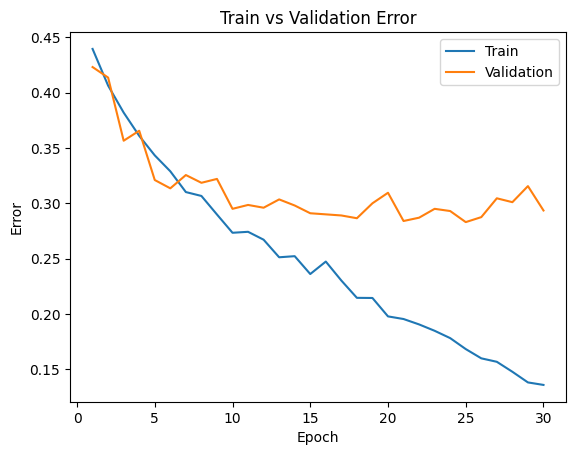

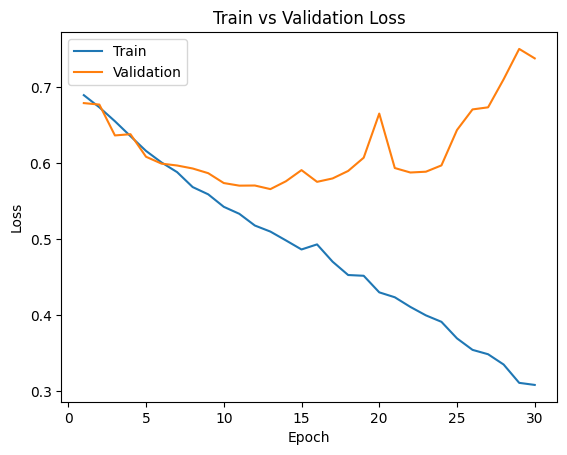

In [ ]:
# For the large_net
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

**Differences between the curves for `small_net` and `large_net`**:
- Training Curve Dynamics:
  - For both loss and error, `small_net` exhibits an exponential decay trend, which suggests a rapid initial improvement that gradually slows down as training progresses.
  - In contrast, `large_net` seems to experience a more linear decline, especially noticeable in the error graph. This suggests a consistent improvement rate across epochs.
- Validation Curve Behavior:
  - The validation curves for `small_net` appear to stabilize more gradually over epochs, hinting at a steady generalization capability as training progresses.
  - For `large_net`, while the error curve displays a gradual decay and stabilization pattern, the validation loss shows noticeable fluctuations after around the 15th epoch. Such behavior might be indicative of the model struggling to generalize consistently or perhaps beginning to overfit to the training data.

**Any occurences of underfitting and overfitting**:
- **`small_net`**:
  - **Overfitting**: There are no strong signs of overfitting for `small_net`. Both the training and validation curves follow similar trends. While there's some divergence between the training and validation metrics as the epochs increase, it's not significantly pronounced.
  - **Underfitting**: `small_net` doesn't show clear evidence of underfitting. However, given that its performance metrics (both error and loss) do not reach particularly low values, it might suggest that the network is not sufficiently complex to capture all underlying patterns of the data.

- **`large_net`**:
  - **Overfitting**: Clear indications of overfitting are visible, especially in the validation loss curve. After around 15 epochs, while the training loss continues to decrease, the validation loss begins to rise. This suggests that `large_net` is fitting very closely to the training data and is not generalizing well to the validation data.
  - **Underfitting**: `large_net` does not show signs of underfitting. The model starts with higher error and loss values but improves rapidly in the initial epochs, indicating its capability to capture the underlying patterns in the training data.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

**Summary**
- **Run time**: 173.86 seconds. With a lower learning rate, the model trained slightly faster than the previous training time of around 180 seconds.

- **Effect**: The model is more stable when the learning rate is slowed down, as shown by the smoother error and loss graphs. This change in rate makes performance consistent between training and validation, which means good generalization and a lower chance of overfitting. Also, the fact that both training and validation loss are slowly going down shows that the model is getting better and learning is staying stable over time.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, learning_rate=0.001)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

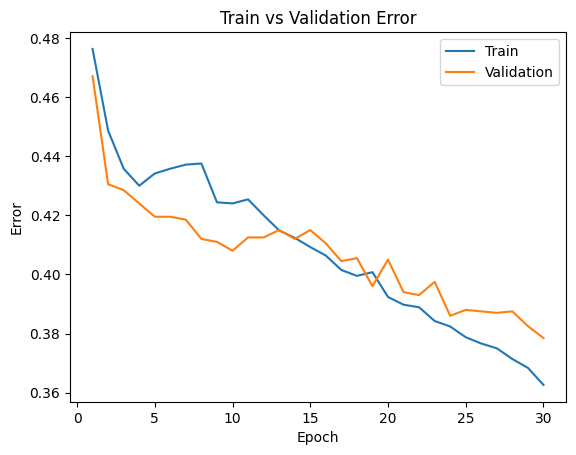

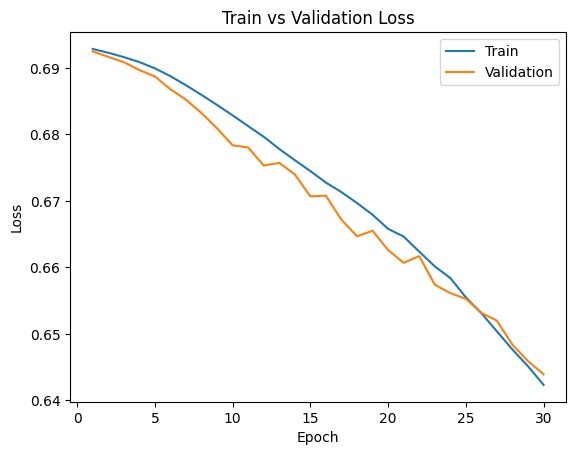

In [ ]:
# For the new large_net
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(large_model_path)

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

**Summary**
- **Run time**: 179.88 seconds. The trained model is very slightly faster than the `large_net` with learning rate of 0.01.

- **Effect**: However, the increased learning rate leads to more significant fluctuations in both the error and loss curves, especially for the validation set. This suggests that the model might be "overshooting" the optimal parameters, leading to potentially unstable training. While the training error and loss show a consistent decline, the validation metrics oscillate considerably, indicating possible overfitting. This inconsistency between training and validation curves suggests that the model may not generalize well to unseen data at this higher learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, learning_rate=0.1)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

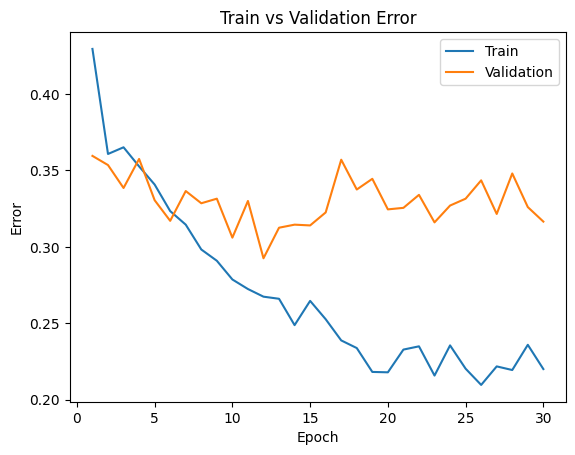

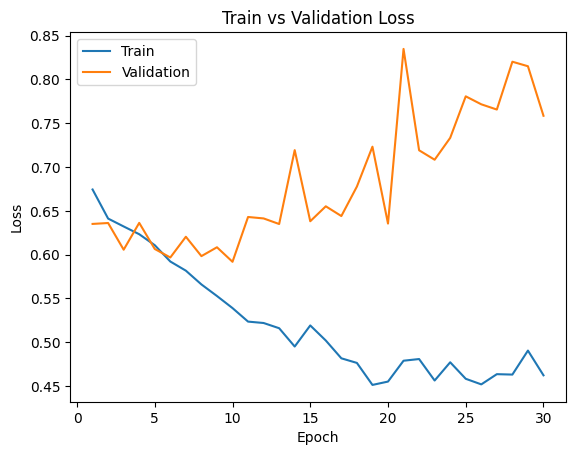

In [ ]:
# For the new large_net
large_model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(large_model_path)

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

**Summary**
- **Run time**: 169.87 seconds. This time, we made an improvement for a shorter run time.

- **Effect**: Increasing the batch size led to smoother error and loss curves for both training and validation, indicating a more stable learning. While the training error and loss shows a consistent reduction, the validation metrics follows it without drastic fluctuations. This suggests that with a larger batch size, the model's updates during training are based on a broader sample of the data, resulting in more generalized and less noisy parameter updates. And this could potentially improve the model's generalization to unseen data, as evidenced by the closer alignment between training and validation curves.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, batch_size=512)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

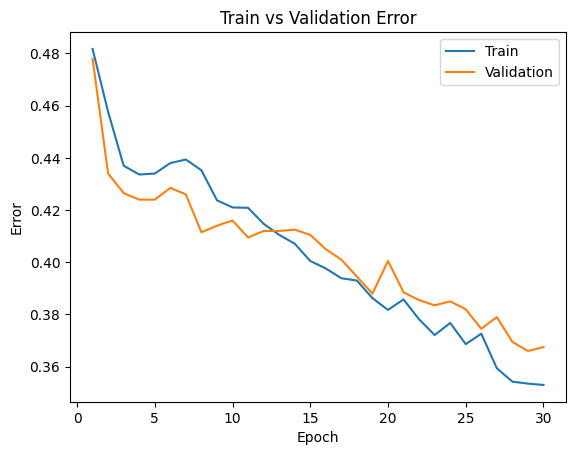

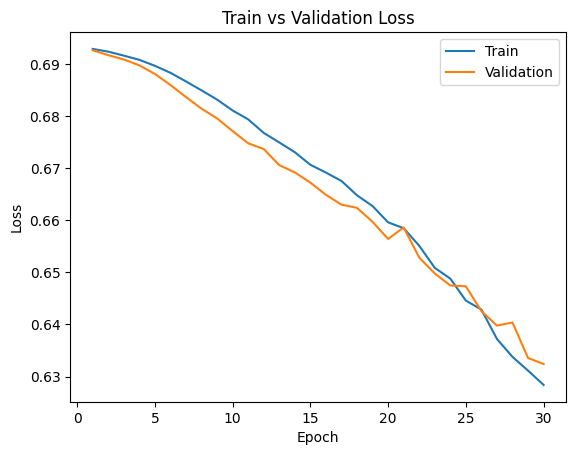

In [ ]:
# For the new large_net
large_model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

**Summary**
- **Run time**: 265.37 seconds. Indeed, the model taks a much longer time to train when we decrease the batch size.

- **Effect**: Reducing the batch size to 16 leads to a more pronounced difference between the training and validation curves. The training error and loss consistently decrease over epochs, indicating that the model is fitting well to the training data. However, the validation error remains relatively stable after initial epochs and the validation loss noticeably increases after the midpoint of the epochs. This divergence between the training and validation metrics implies that the model might be overfitting, capturing the noise or fluctuations in the training data.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, batch_size=16)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

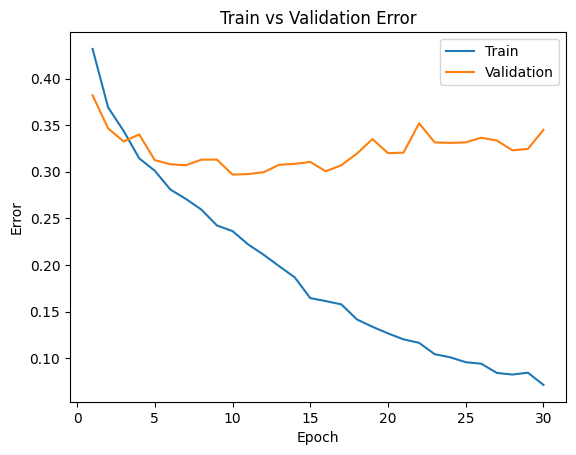

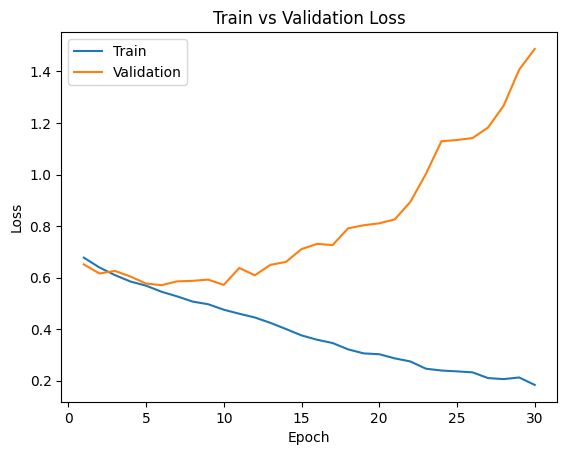

In [ ]:
# For the new large_net
large_model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(large_model_path)

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

**Selected Hyperparameters:**
- **Network**: **`small_net`**
- **Batch Size**: **256**
- **Learning Rate**: **0.01**

**Reasoning:**

- **Network Choice**: I chose the `small_net` due to its consistent and stable performance in previous experiments. Smaller networks, with fewer parameters, tend to be less prone to overfitting. Also based on our observations, the small_net seems to generalize well for this dataset.

- **Batch Size Selection**: A batch size of 256 is chosen as a compromise between training speed and model update frequency. Larger batches offer quicker training by processing more data at once, but I also want to ensure frequent enough updates to the model's weights. The size of 256 provides a good balance based on prior results.

- **Learning Rate Decision**: I choose keep the learning rate as 0.01, since past experiments show a relatively smooth learning curves for both loss and error graphs.

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
small_net = SmallNet()

train_net(small_net, batch_size=256, learning_rate=0.01, num_epochs=45)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.478625, Train loss: 0.6940148584544659 |Validation err: 0.4425, Validation loss: 0.6816106736660004
Epoch 2: Train err: 0.415, Train loss: 0.6740579474717379 |Validation err: 0.399, Validation loss: 0.6683318689465523
Epoch 3: Train err: 0.387, Train loss: 0.6624149214476347 |Validation err: 0.3715, Validation loss: 0.6569532230496407
Epoch 4: Train err: 0.365125, Train loss: 0.6497500389814377 |Validation err: 0.372, Validation loss: 0.6481828689575195
Epoch 5: Train err: 0.36925, Train loss: 0.646163921803236 |Validation err: 0.3715, Validation loss: 0.6450235396623611
Epoch 6: Train err: 0.361375, Train loss: 0.6427852213382721 |Validation err: 0.372, Validation loss: 0.6451346278190613
Epoch 7: Train err: 0.35825, Train loss: 0.6393346805125475 |Validation err: 0.3635, Validation loss: 0.6433067172765732
Epoch 8: Train err: 0.35875, Train loss: 0.6374388486146927 |Validation err: 0.362

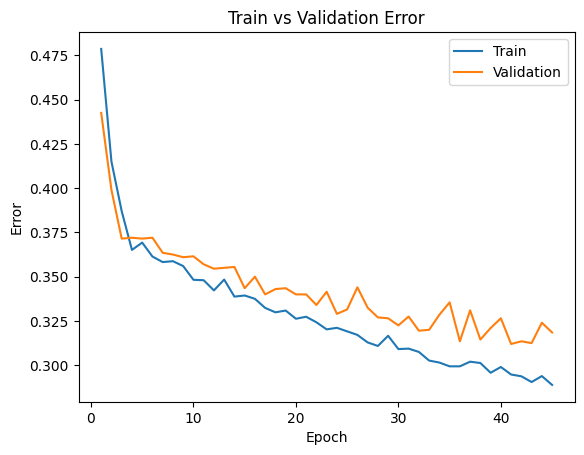

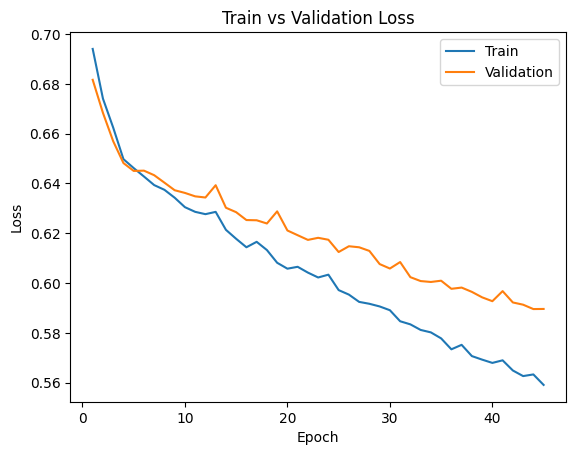

In [ ]:
# For the new small_net
small_model_path = get_model_name("small", batch_size=256, learning_rate=0.01, epoch=44)
plot_training_curve(small_model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try.
Justify your choice.

**2nd set of Hyperparameters:**
- **Network**: **`large_net`**
- **Batch Size**: **192**
- **Learning Rate**: **0.0069**

**Reasoning:**

- **Network Choice**: Since no significant improvement was seen in the last experiments for `small_net`, I switched to try and see if I can make any improvment by using the `large_net`.

- **Batch Size Selection**: I chose to have a batch size of 192 to balance training speed with model update frequency. And a relatively larger size has previously shown to provide smoother learning curves.

- **Learning Rate Decision**: I chose to reduce the learning rate to see if the error and loss curves can have a better convergence.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, batch_size=192, learning_rate=0.0069, num_epochs=45)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48775, Train loss: 0.6924460870879037 |Validation err: 0.465, Validation loss: 0.691893837668679
Epoch 2: Train err: 0.456875, Train loss: 0.6908166138898759 |Validation err: 0.4555, Validation loss: 0.6903375278819691
Epoch 3: Train err: 0.456375, Train loss: 0.68903487211182 |Validation err: 0.4445, Validation loss: 0.6883790980685841
Epoch 4: Train err: 0.44825, Train loss: 0.686548494157337 |Validation err: 0.425, Validation loss: 0.684754566712813
Epoch 5: Train err: 0.435125, Train loss: 0.6837085485458374 |Validation err: 0.4245, Validation loss: 0.6823253956708041
Epoch 6: Train err: 0.435, Train loss: 0.6811381791319165 |Validation err: 0.424, Validation loss: 0.6796745874665
Epoch 7: Train err: 0.4255, Train loss: 0.6775079085713341 |Validation err: 0.4185, Validation loss: 0.6768910884857178
Epoch 8: Train err: 0.424125, Train loss: 0.6745370470342182 |Validation err: 0.411, Val

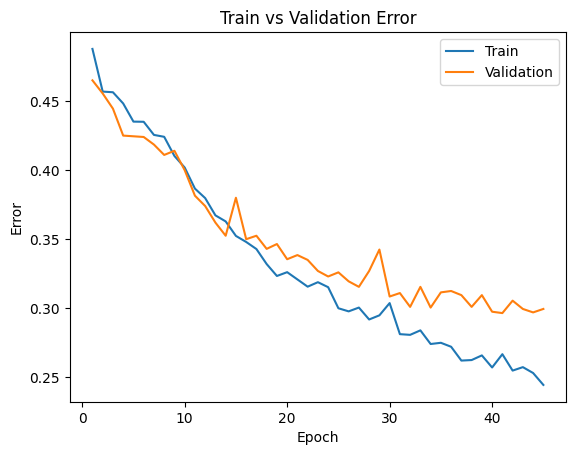

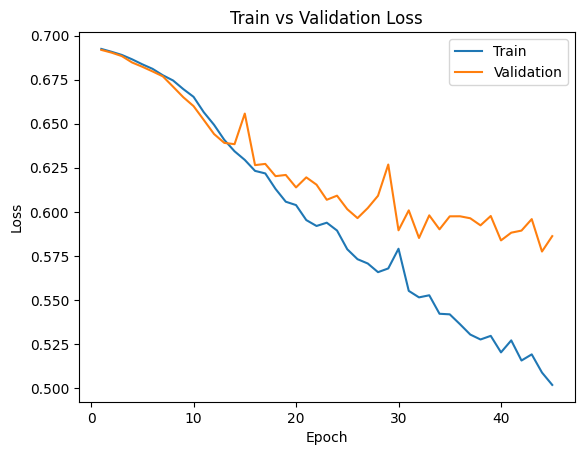

In [ ]:
# For the new large_net
large_model_path = get_model_name("large", batch_size=192, learning_rate=0.0069, epoch=44)
plot_training_curve(large_model_path)

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`,
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=256, learning_rate=0.01, epoch=44)

state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

- While  both trained `large_net` and `small_net` gave us comparable results, I chose the `small_net` model because its learning curves showed a more stable and consistent decay in validation error and loss.

- Additionally, given the similar performance between the two, the simpler `small_net` is chosen because of its reduced computational requirements and potential to generalize better to new data.

- The smaller gap between training and validation curves in `small_net` also hints at a reduced chance of overfitting compared to `large_net`.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
def evaluate_on_test(net, test_loader, criterion):
    """ Evaluate the network on the test set.

     Args:
         net: PyTorch neural network object
         test_loader: PyTorch data loader for the test set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the test set
         loss: A scalar for the average loss function over the test set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=256)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Compute validation error and loss
val_err, val_loss = evaluate(net, val_loader, nn.BCEWithLogitsLoss())

# Compute test error and loss
test_err, test_loss = evaluate_on_test(net, test_loader, nn.BCEWithLogitsLoss())

# Display results
print(f"Validation error: {val_err:}\nValidation loss: {val_loss:}\n")
print(f"Test error: {test_err:}\nTest loss: {test_loss:}")

Validation error: 0.3185
Validation loss: 0.5881778672337532

Test error: 0.311
Test loss: 0.5760546997189522


### Part (d) - 3pt

How does the **test classification error** compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The result in part (c) shows that the test error is slightly lower than the validation error by about 0.0075. At first glance, this is counterintuitive since the model encounters the test data for the first time and one might expect a higher error rate.

However, a few factors could explain this outcome:

1. **Random Variability**: The small difference of 0.0075 might be due to random variability in the samples of the validation and test sets. Sometimes, the test set might have "easier" examples for the model to classify.

2. **Data Split Quality**: The closeness in error rates could suggest that both validation and test sets are of similar quality and representativeness.

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

- We only use the test set at the very end because it ensures an unbiased evaluation of our model's ability to generalize to unseen data.

- And, it is important to use the test data as liitle as possible because testing too frequently can lead to overfitting, where the model start memorizing the test data and may not perform well on truly new data.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.name = "ANN"
        self.fc1 = nn.Linear(3 * 32 * 32, 64) # First fully connected layer
        self.fc2 = nn.Linear(64, 1)           # Second fully connected layer

    def forward(self, img):
        # Flatten the RGB image
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = F.relu(self.fc1(flattened))
        activation2 = self.fc2(activation1)
        activation2 = activation2.squeeze(1) # remove any extra dimensions of size 1
        return activation2

In [ ]:
# Define and traing the ANN
ANN_net = ANN()
train_net(ANN_net, batch_size=512, learning_rate=0.003, num_epochs=30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47925, Train loss: 0.6909849718213081 |Validation err: 0.437, Validation loss: 0.6833898723125458
Epoch 2: Train err: 0.414875, Train loss: 0.6763791851699352 |Validation err: 0.423, Validation loss: 0.6725558340549469
Epoch 3: Train err: 0.402625, Train loss: 0.6678616292774677 |Validation err: 0.41, Validation loss: 0.6675644367933273
Epoch 4: Train err: 0.398, Train loss: 0.6625241711735725 |Validation err: 0.406, Validation loss: 0.6635131388902664
Epoch 5: Train err: 0.393, Train loss: 0.6578166261315346 |Validation err: 0.4045, Validation loss: 0.66108138859272
Epoch 6: Train err: 0.389, Train loss: 0.6550047770142555 |Validation err: 0.3965, Validation loss: 0.6583944708108902
Epoch 7: Train err: 0.38375, Train loss: 0.6517799533903599 |Validation err: 0.394, Validation loss: 0.6573571115732193
Epoch 8: Train err: 0.378375, Train loss: 0.6489585004746914 |Validation err: 0.3905, Val

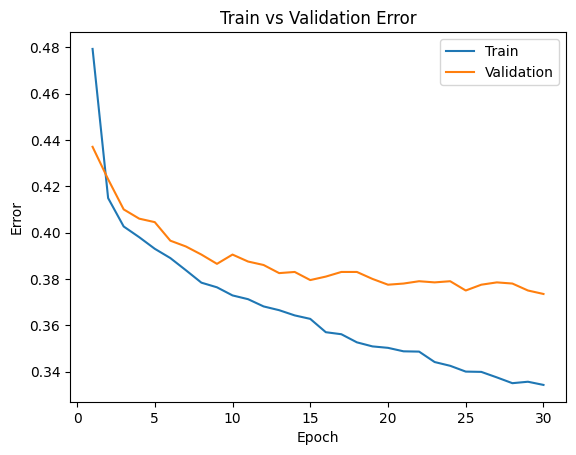

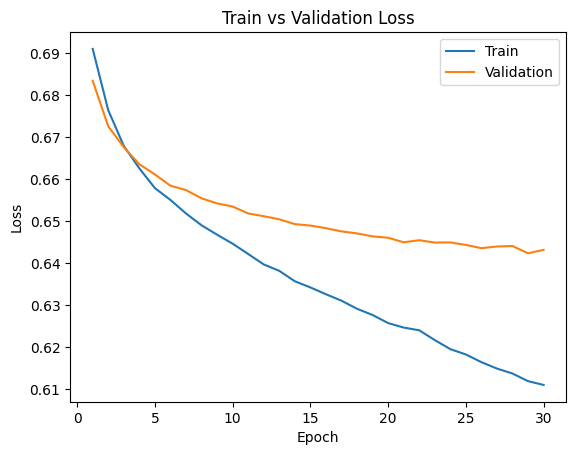

In [ ]:
# Visualize the error and loss curves
ANN_model_path = get_model_name("ANN", batch_size=512, learning_rate=0.003, epoch=29)
plot_training_curve(ANN_model_path)

In [ ]:
# Prepare the trained 2-layer ANN model
ANN_net = ANN()
model_path = get_model_name(ANN_net.name, batch_size=512, learning_rate=0.003, epoch=29)

state = torch.load(model_path)
ANN_net.load_state_dict(state)

<All keys matched successfully>

In [ ]:
# Loads the data sets
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"],
    batch_size=512)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Compute test error and loss
test_err, test_loss = evaluate_on_test(ANN_net, test_loader, nn.BCEWithLogitsLoss())

# Display results
print(f"2-layer ANN:\nTest error: {test_err:}\nTest loss: {test_loss:}")

2-layer ANN:
Test error: 0.36
Test loss: 0.6417338699102402


**Comparing the 2-layer ANN and the `simple_net` CNN**:
- Recall from part (c) that the test error for our `simple_net` CNN model is only 0.311 as compared to our test error of 0.36 for the 2-layer ANN model that we have just played with.
- It is clear that CNN model architecture  performs better than the ANN model architecture for image classification  tasks.